<a href="https://colab.research.google.com/github/liotti2085/Bayesian-Hierarchical-Model-for-Prediction-of-Soccer-Scores/blob/main/Bayesian_Hierarchical_Model_for_Football_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the required libraries and data.

In [ ]:
!pip install arviz
import arviz as az
from google.colab import files
import io
import pickle
import pystan
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['scores.csv']))

Saving scores.csv to scores.csv


Get the variables in their proper format for modelling in Stan.

In [3]:
ngames = df.shape[0]
npredict = 5
ngob = ngames - npredict
nteams = len(np.unique(df.iloc[:,1]))
home_name = df.iloc[:, 1]
away_name = df.iloc[:, 2]
home_team_index = pd.Categorical(df['home_team']).codes
away_team_index = pd.Categorical(df['away_team']).codes
home_score = df.iloc[:, 5]
away_score = df.iloc[:, 6]
home_team_new = home_team_index[(ngob):ngames]
away_team_new = away_team_index[(ngob):ngames]
names = np.unique(home_name)

Now we need to increase all of the index values by one since Stan starts indexing at 1 not 0.

In [4]:
bleh = [1] * ngames
bleh += home_team_index
home_team_index = bleh

bleh = [1] * ngames
bleh += away_team_index
away_team_index = bleh

In [ ]:
away_team_index
home_team_index

Model 1: Standard Hierarchical Model

In [ ]:
model_1 = """
data {
  int<lower=0> nteams; //number of teams
  int<lower=0> ngames; //number of games
  int<lower=0> home_team[ngames]; //home team index
  int<lower=0> away_team[ngames]; //away team index
  int<lower=0> home_score[ngames]; //score home team
  int<lower=0> away_score[ngames]; //score away team
  int<lower=0> npredict; //number of games to predict
  int<lower=0> home_team_new[npredict]; //home teams for prediction
  int<lower=0> away_team_new[npredict]; //away teams for prediction
}

parameters {
  real home; //home advantage
  vector[nteams] att_star; 
  vector[nteams] def_star; 

  //hyperparameters

  real mu_att;
  real<lower = 0> sigma_att;
  real mu_def;
  real<lower = 0> sigma_def;
}

transformed parameters {
  vector[ngames] theta1; //score probability of home team
  vector[ngames] theta2; //score probability of away team
  vector[nteams] att; //attack ability of each team
  vector[nteams] def; //defence ability of each team

  att = att_star - mean(att_star);
  def = def_star - mean(def_star);
  
  theta1 = exp(home + att[home_team] + def[away_team]);
  theta2 = exp(att[away_team] + def[home_team]);
}

model {
  //hyperparams

  mu_att ~ normal(0, 100);
  sigma_att ~ inv_gamma(1, 1);
  mu_def ~ normal(0, 100);
  sigma_def ~ inv_gamma(1, 1);
}

  //priors
  att_star ~ normal(mu_att, sigma_att);
  def_star ~ normal(mu_def, sigma_def);
  home ~ normal(0, 100);

  //likelihood
  home_score ~ poisson(theta1);
  away_score ~ poisson(theta2);
}

generated quantities {
  //generated prediction
  vector[npredict] theta1new; //score probability of home team
  vector[npredict] theta2new; //score probability of away team
  real home_score_new[npredict]; //predicted home score
  real away_score_new[npredict]; //predicted away score

  theta1new = exp(home + att[home_team_new] + def[away_team_new]);
  theta2new = exp(att[away_team_new] + def[home_team_new]);

  home_score_new = poisson_rng(theta1new);
  away_score_new = poisson_rng(theta2new);
}
"""

Model 2: Hierarchical Mixture Model

In [5]:
model_2 = """
data {
  int<lower=0> nteams; //number of teams
  int<lower=0> ngames; //number of games
  int<lower=0> home_team[ngames]; //home team index
  int<lower=0> away_team[ngames]; //away team index
  int<lower=0> home_score[ngames]; //score home team
  int<lower=0> away_score[ngames]; //score away team
  int<lower=0> npredict; //number of games to predict
  int<lower=0> home_team_new[npredict]; //home teams for prediction
  int<lower=0> away_team_new[npredict]; //away teams for prediction
}

parameters {
  real home; //home advantage
  vector[nteams] att_star; 
  vector[nteams] def_star; 

  //hyperparameters

  //model 2
  vector[3] mu_att;
  vector<lower=0>[3] sigma_att;
  vector[3] mu_def;
  vector<lower=0>[3] sigma_def;

  simplex[3] pi_att; //probability vector for latent groups model 2
  simplex[3] pi_def;
}

transformed parameters {
  vector[ngames] theta1; //score probability of home team
  vector[ngames] theta2; //score probability of away team
  vector[nteams] att; //attack ability of each team
  vector[nteams] def; //defence ability of each team

  att = att_star - mean(att_star);
  def = def_star - mean(def_star);
  
  theta1 = exp(home + att[home_team] + def[away_team]);
  theta2 = exp(att[away_team] + def[home_team]);
}

model {
  vector[3] log_theta_att = log(pi_att);
  vector[3] log_theta_def = log(pi_def);

  //hyperparams
  //model 1
  
  //model 2
  mu_att[1] ~ normal(0, 10) T[-3, 0];
  mu_def[1] ~ normal(0, 10) T[0, 3];
  mu_att[2] ~ normal(0, sigma_att[2]);
  mu_def[2] ~ normal(0, sigma_def[2]);
  mu_att[3] ~ normal(0, 10) T[0, 3];
  mu_def[3] ~ normal(0, 10) T[-3, 0];

  sigma_att[1] ~ inv_gamma(1, 1);
  sigma_def[1] ~ inv_gamma(1, 1); 
  sigma_att[2] ~ inv_gamma(1, 1);
  sigma_def[2] ~ inv_gamma(1, 1);
  sigma_att[3] ~ inv_gamma(1, 1);
  sigma_def[3] ~ inv_gamma(1, 1);

  pi_att ~ dirichlet([1,1,1]');
  pi_def ~ dirichlet([1,1,1]');

  for (n in 1:nteams) {
    vector[3] lps_att = log_theta_att;
    vector[3] lps_def = log_theta_def;
    for (k in 1:3) {
      lps_att[k] += student_t_lpdf(att_star[n] | 4, mu_att[k], sigma_att[k]);
      lps_def[k] += student_t_lpdf(def_star[n] | 4, mu_def[k], sigma_def[k]);
    }
    target += log_sum_exp(lps_att);
    target += log_sum_exp(lps_def);
   
  }

  //priors
  //att_star ~ normal(mu_att, sigma_att); //model 1
  //def_star ~ normal(mu_def, sigma_def); //model 1
  home ~ normal(0, 100);

  //likelihood
  home_score ~ poisson(theta1);
  away_score ~ poisson(theta2);
}

generated quantities {
  //generated prediction
  vector[npredict] theta1new; //score probability of home team
  vector[npredict] theta2new; //score probability of away team
  real home_score_new[npredict]; //predicted home score
  real away_score_new[npredict]; //predicted away score

  theta1new = exp(home + att[home_team_new] + def[away_team_new]);
  theta2new = exp(att[away_team_new] + def[home_team_new]);

  home_score_new = poisson_rng(theta1new);
  away_score_new = poisson_rng(theta2new);
}
"""

data = {
    'nteams' : nteams,
    'ngames' : ngames,
    'home_team' : home_team_index,
    'away_team' : away_team_index,
    'home_score' : home_score,
    'away_score' : away_score,
    'npredict' : npredict,
    'home_team_new' : home_team_new,
    'away_team_new' : away_team_new
}

In [ ]:
mod = pystan.StanModel(model_code=model_2)
fit = mod.sampling(data = data, iter=5000, warmup=500, chains=4, control=dict(max_treedepth = 14, adapt_delta = .9))

In [ ]:
print(fit)

In [ ]:
az.style.use('arviz-darkgrid')
inf_data = az.convert_to_inference_data(fit)
az.plot_energy(inf_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc56d2ec1d0>,
      dtype=object)

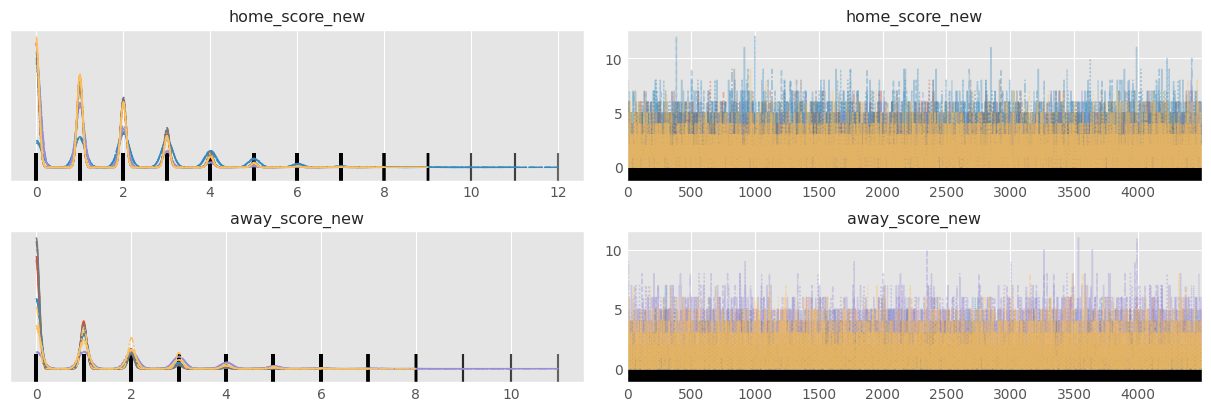

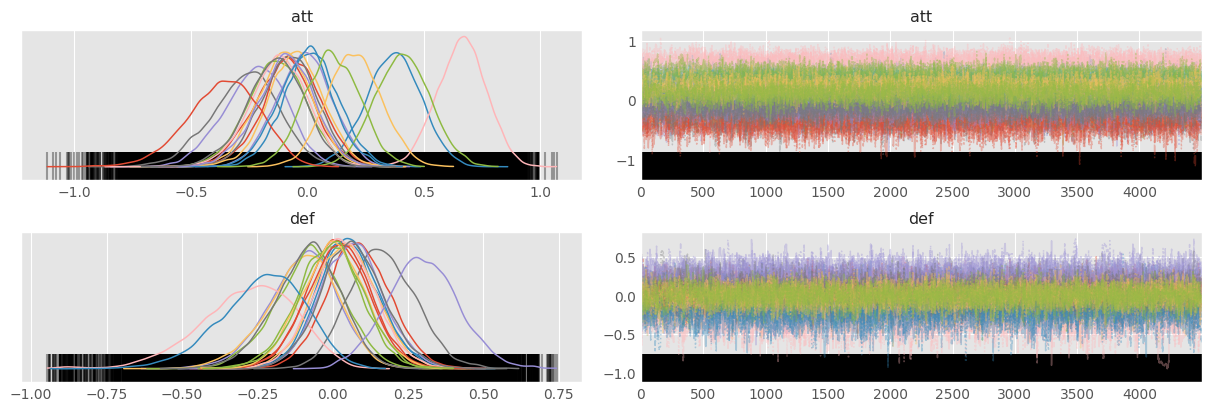

In [ ]:
az.plot_trace(fit,var_names=['home_score_new', 'away_score_new'])
az.plot_trace(fit, var_names=['att', 'def'], combined=True)

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates


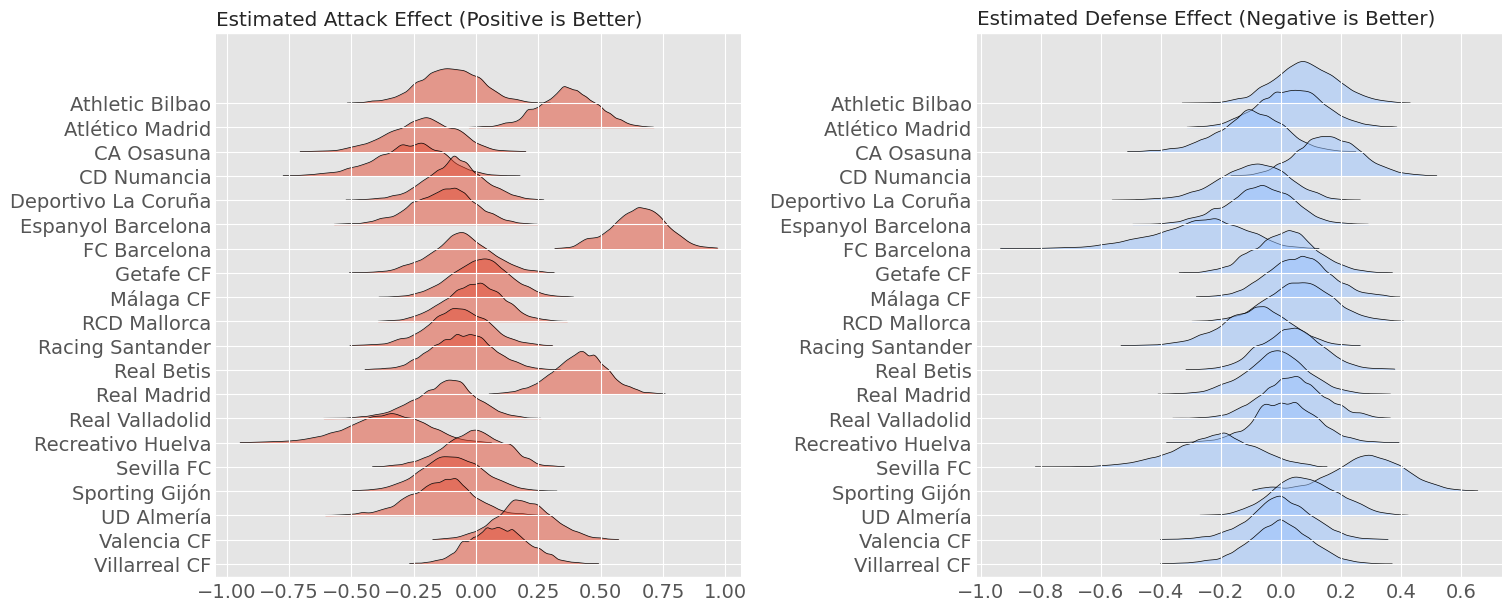

In [9]:
plt.style.use('ggplot')
_, ax = plt.subplots(1, 2, figsize=(15, 6))
az.plot_forest(fit, var_names="att",combined=True, ax=ax[0], kind='ridgeplot', ridgeplot_alpha=.5, ridgeplot_overlap=1.5, hdi_prob=.999, linewidth=.5)
ax[0].set_yticklabels(sorted(names, reverse=True))
ax[0].set_title('Estimated Attack Effect (Positive is Better)', loc='left')
ax[0].grid(True)
az.plot_forest(fit, var_names="def", combined=True, ax=ax[1], kind='ridgeplot', ridgeplot_alpha=.5, ridgeplot_overlap=1.5, colors='#99c2ff', hdi_prob=.999,
               linewidth=.5)
ax[1].set_yticklabels(sorted(names, reverse=True))
ax[1].set_title('Estimated Defense Effect (Negative is Better)', loc='left')
ax[1].grid(True)

In [ ]:
az.plot_parallel(inf_data, var_names=['sigma_att','sigma_def'])

In [ ]:
az.plot_posterior(fit)

In [ ]:
samples = fit.extract()
atts = samples['att']
defs = samples['def']